In [66]:
import torch
import torch as T
from torch import nn
from torch.autograd import Variable
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(123);

dtype = torch.float
device = torch.device("cpu")

## Sample Data

In [67]:
n_points = 12
X = torch.rand(n_points, 1)


def f(X, noise=0.1): 
    
    # Function
    y = torch.sin(12 * X) + 0.6 * torch.cos(25 * X) + 3
    
    # Add noise
    y += noise * torch.randn(X.size(0), 1)
    return y.squeeze(1)

Y = f(X)



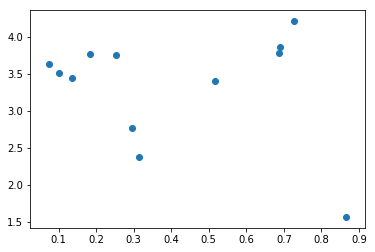

In [68]:
fig, ax = plt.subplots()

ax.scatter(X.numpy(), Y.numpy())

### ARD Kernel

In [69]:
class ARD(nn.Module):
    """ARD Kernel function that supports both the """
    def __init__(self, d_dims=None, 
                 sigma0=None, 
                 nu0=None):
        super(ARD, self).__init__()
        # Initialize dimensionality of the data
        if d_dims is None:
            d_dims = 1
            
        self.d_dims = d_dims # Number of dimensions
        
        # Initialize length_scale
        if sigma0 is None:
            sigma0 = torch.ones(d_dims)*0.05
        self.sigma = nn.Parameter(sigma0)
        
        # Initialize signal variance
        if nu0 is None:
            nu0 = torch.ones(1)*0.1
        self.nu = nn.Parameter(nu0)
        
    def forward(self, X, Y=None):
        
        if Y is None:
            Y = X
        diff = (X / self.sigma).unsqueeze(1) - (Y / self.sigma).unsqueeze(0)
        
        return self.nu * diff.pow_(2).sum(-1).mul(-0.5).exp_()

#### Test

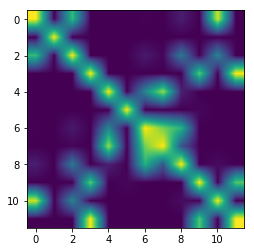

In [70]:
kernel = ARD(X.size(1))

K = kernel.forward(X)

fig, ax = plt.subplots()

ax.imshow(K.data.numpy(), interpolation='bilinear')

plt.show()

### Cholesky Decomposition

In [152]:
class Cholesky(torch.autograd.Function):
    """Function that computes the Cholesky Decomposition"""
    @staticmethod
    def forward(ctx, a):
        L = torch.potrf(a, False)
        ctx.save_for_backward(L)
        return L
    @staticmethod
    def backward(ctx, grad_output):
        L, = ctx.saved_variables
        
        L_inv = L.inverse()
        
        inner = torch.tril(torch.mm(L.t(), grad_output)) \
            * torch.tril(1.0 - Variable(L.data.new(L.size(
        1)).fill_(0.5).diag()))
        
        s = torch.mm(L_inv.t(), torch.mm(inner, L_inv))
        
#         s = (s+s.t())/2.0
        
        return s

#### Testing

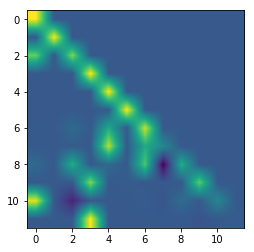

torch.Size([12, 12]) torch.Size([12, 12])


In [153]:
L = Cholesky.apply(K)

fig, ax = plt.subplots()

ax.imshow(L.data.numpy(), interpolation='bilinear')

plt.show()

K_approx = torch.mm(L, L.t())

print(L.size(), K_approx.size())
np.testing.assert_array_almost_equal(K.data.numpy(), 
                                  K_approx.data.numpy())

### Gaussian Likelihood

In [154]:
# class GaussianLikelihood(nn.Module):
#     def __init__(self, log_noise_prior=None):

## Standard GP

##### TODO

* Remove Mean from lables
* MeanFunction Class
* GaussianLikelihood Class
* GaussianRandomVariable Class

In [155]:
np.log(2*np.pi)

1.8378770664093453

In [156]:
LOG2PI = np.log(2*np.pi)
class GPR(nn.Module):
    def __init__(self, X, y, kernel, noise0=None):
        super(GPR, self).__init__()
        
        # Noise Likelihood for the Model
        if noise0 is None:
            noise0 = torch.ones(1)
        elif np.isscalar(noise0):
            noise0 = torch.FloatTensor(1).fill_(noise0)
        self.noise = nn.Parameter(noise0)
        self.jitter = torch.FloatTensor(1).fill_(10e-3)
        
        # Initialize kernel (RBF)
        self.kernel = kernel
        
        # Initialize Variables
        self.Xtrain = X
        self.ytrain = y
        self.n_samples = X.size(0)
        self.d_dimensions = X.size(1)
            
    def forward(self):
                
        # Training Kernel on training data
        Ktrain = self.kernel(self.Xtrain)
        
        # Add noise
        Ktrain += self.noise * Variable(torch.eye(self.n_samples))
        
        # Cholesky decomposition of Kernel
        L = Cholesky.apply(Ktrain+ self.jitter * Variable(torch.eye(self.n_samples)))

#         try:
#             L = Cholesky.apply(Ktrain )
#         except RuntimeError:
#             return self.old_lml
        # Weights
        weights = torch.mv(Ktrain.inverse(), self.ytrain)
        
        # Calculate the log marginal likelihood
        neg_lml = self._log_marginal_likelihood(L, weights)
#         neg_lml = 0.5 * self.ytrain.dot(weights) 
#         neg_lml += L.diag().log().sum() 
#         neg_lml += self.ytrain.size(0) / (2.0 * LOG2PI)
        
        self.old_lml = neg_lml
        
        return neg_lml
    def fit(self):
        
        self.K = self.kernel(self.Xtrain) + self.noise * Variable(torch.eye(self.n_samples))
        self.Kinv = torch.inverse(self.K)
        
        self.Kt = self.kernel(X)
        
        self.alpha = torch.mv(self.Kinv, self.ytrain)
        
        
        return self
    def predict(self, X, return_std=False, return_cov=False):
        
#         K = self.kernel(self.Xtrain) + self.noise * Variable(torch.eye(self.n_samples))
#         Kinv = torch.inverse(K)
        
#         Kt = self.kernel(X)

        Ktrans = self.kernel(X, self.Xtrain)
        
        
        
        mu = torch.mv(Ktrans, self.alpha).unsqueeze(1)
        
        if return_cov or return_std:
            Kt = self.kernel(X)
            cov = Kt - torch.mm(Ktrans, torch.mm(self.Kinv, Ktrans.t()))
            
        if return_std:
            y_std = cov.diag()
            return mu, y_std.sqrt()
        else:
            return mu
        
        
        
    def _log_marginal_likelihood(self, L, weights):
        
        neg_lml = 0.5 * self.ytrain.dot(weights) 
        neg_lml += L.diag().log().sum() 
        neg_lml += self.ytrain.size(0) / (2.0 * LOG2PI)
        
        return neg_lml
        
        

In [157]:
N = 30

X = torch.linspace(0, 1, N).unsqueeze(1)
# Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1)*0.1 + 3).squeeze(1)
# Y = (torch.sin(X) * torch.exp(0.2 * X) +  0.1 * torch.randn(N,1)).squeeze()

Y = torch.sin(X.data * (2 * np.pi)) + torch.randn(X.size()) * 0.2

print(X.size(), Y.size())
X_mean = X.mean()
Xtrain = (X-X_mean)

fig, ax = plt.subplots()

ax.scatter(Xtrain, Y)

plt.show()

torch.Size([30, 1]) torch.Size([30, 1])


In [158]:


# Choose Kernel
kernel = ARD(1)

# Choose GP Model
gp_model = GPR(Variable(Xtrain), Variable(Y.squeeze()), kernel=kernel, noise0=0.1)



In [159]:
def closure():
    opt.zero_grad()
    nlogp = gp_model.forward()
    nlogp.backward()
    return nlogp

# Choose Optimziation
opt = torch.optim.LBFGS(gp_model.parameters(), lr=0.1)

for i in range(100):
    
    # Zero gradients from previous iteration
    opt.zero_grad()
    
    # output from the model
    nlogp = gp_model.forward()
    
    # Calculate the loss and backprop gradients
    nlogp.backward()
    
    
    opt.step(closure)
#     print(nlogp.data[0])
print('Done', nlogp.data[0])

/Users/eman/anaconda3/envs/gpytorch/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # Remove the CWD from sys.path while we load stuff.


Done tensor(-12.9347)


/Users/eman/anaconda3/envs/gpytorch/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [160]:
print(gp_model.kernel.nu)
print(gp_model.kernel.sigma)
print(gp_model.noise)


Parameter containing:
tensor([0.6375], requires_grad=True)
Parameter containing:
tensor([0.2391], requires_grad=True)
Parameter containing:
tensor([0.0451], requires_grad=True)


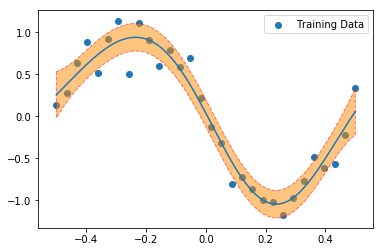

In [161]:
xtest = torch.linspace(0, 1, 1000)
xtest -= X_mean
gp_model.fit()
mean, std = gp_model.predict(Variable(xtest.unsqueeze(1)), return_std=True)




low = mean.data.numpy().squeeze() - 1.96 * std.data.numpy().squeeze()
high = mean.data.numpy().squeeze() + 1.96 * std.data.numpy().squeeze()
fig, ax = plt.subplots()

ax.scatter(Xtrain.numpy(), Y.numpy(), label='Training Data')
ax.plot(xtest.numpy(), mean.data.numpy())
ax.fill_between(xtest.numpy(),
                low,
                high,
                edgecolor='red',
                facecolor='darkorange', 
                alpha=0.5, linestyle='--')

ax.legend()
plt.show()

### Gradient of Predictive Function

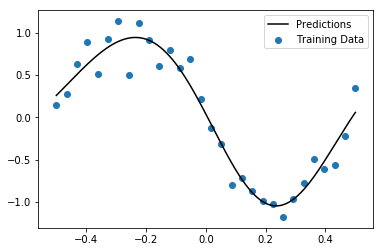

In [162]:
xtest = torch.linspace(0, 1, 1000)
xtest -= X_mean
X = Variable(xtest.unsqueeze(1), requires_grad=True)

Ktrans = gp_model.kernel(X, gp_model.Xtrain)

pred = torch.mm(Ktrans, gp_model.alpha.unsqueeze(1))

fig, ax = plt.subplots()

ax.scatter(Xtrain.numpy(), Y.numpy(), label='Training Data')
ax.plot(xtest.numpy(), pred.data.numpy(),  color='k', label='Predictions')

ax.legend()
plt.show()

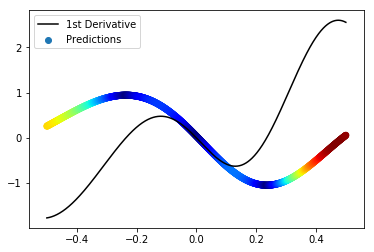

In [163]:
pred.backward(gradient=X, retain_graph=True)

pred_grad = X.grad.numpy()

fig, ax = plt.subplots()

ax.scatter(xtest.numpy(), pred.data.numpy(), c=np.abs(pred_grad), cmap=plt.cm.jet, label='Predictions')
ax.plot(xtest.numpy(), pred_grad, color='k', label='1st Derivative')

ax.legend()
plt.show()

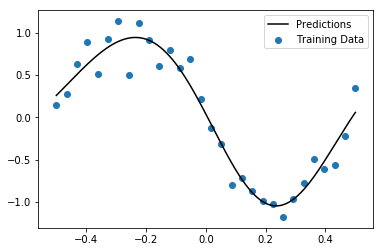

In [164]:
xtest = torch.linspace(0, 1, 1000)
xtest -= X_mean
X = Variable(xtest.unsqueeze(1), requires_grad=True)

pred = gp_model.predict(X)



fig, ax = plt.subplots()

ax.scatter(Xtrain.numpy(), Y.numpy(), label='Training Data')
ax.plot(xtest.numpy(), pred.data.numpy(),  color='k', label='Predictions')

ax.legend()
plt.show()

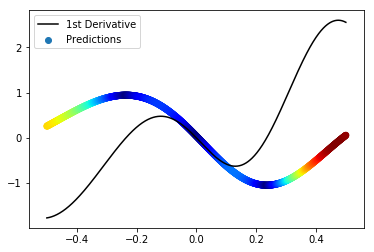

In [165]:
pred.backward(gradient=xtest.unsqueeze(1), retain_graph=True)

pred_grad = X.grad.numpy()

fig, ax = plt.subplots()

ax.scatter(xtest.numpy(), pred.data.numpy(), c=np.abs(pred_grad), cmap=plt.cm.jet, label='Predictions')
ax.plot(xtest.numpy(), pred_grad, color='k', label='1st Derivative')

ax.legend()
plt.show()